# Engenharia de Atributos

In [1]:
import logging

logging.basicConfig(
    level=logging.INFO,
    format='%(asctime)s - %(levelname)s - %(message)s',
    datefmt='%Y-%m-%d %H:%M:%S'
)

In [2]:
import pandas as pd

nome_arquivo = f'2.atributos.parquet'
df = pd.read_parquet(nome_arquivo)

2025-06-01 14:38:52 - INFO - NumExpr defaulting to 8 threads.


In [3]:
df = df[df.municipio == 'Conselheiro Lafaiete']

## TODO: Analisar anomalia abaixo

In [4]:
vc = df.novos_casos_novos.value_counts().reset_index()
vc[vc.novos_casos_novos < 0]

,novos_casos_novos,count
71,-27270,2
93,-27229,1
95,-1,1
155,-435,1
156,-48,1
157,-4,1
158,-8,1


In [5]:
print(len(df))
display(df[(df.novos_casos_novos == -27270) | (df.novos_casos_novos == -27229) | (df.novos_casos_novos == 27270) | (df.novos_casos_novos == 27232)])
df = df[(df.novos_casos_novos != 27232) & (df.novos_casos_novos != 27270) & (df.novos_casos_novos >= 0)]

1849


,regiao,estado,municipio,coduf,codmun,cod_regiao_saude,nome_regiao_saude,data,semana_epi,populacao_tcu_2019,...,obitos_acumulados,obitos_novos,interior_metropolitana,novos_casos_novos,novos_casos_acumulados,mes,mes_traduzido,dia_semana,dia_semana_traduzido,estacao
2438901,Sudeste,MG,Conselheiro Lafaiete,31,311830.0,31079.0,CONSELHEIRO LAFAIETE,2020-06-05,23,128589.0,...,337,337,0.0,27232,27271,June,Junho,Friday,Sexta-feira,Outono
2438902,Sudeste,MG,Conselheiro Lafaiete,31,311830.0,31079.0,CONSELHEIRO LAFAIETE,2020-06-06,23,128589.0,...,0,-337,0.0,-27229,42,June,Junho,Saturday,Sábado,Outono
2440443,Sudeste,MG,Conselheiro Lafaiete,31,311830.0,31079.0,CONSELHEIRO LAFAIETE,2024-08-25,35,128589.0,...,674,337,0.0,27270,54540,August,Agosto,Sunday,Domingo,Inverno
2440444,Sudeste,MG,Conselheiro Lafaiete,31,311830.0,31079.0,CONSELHEIRO LAFAIETE,2024-08-26,35,128589.0,...,337,-337,0.0,-27270,27270,August,Agosto,Monday,Segunda-feira,Inverno
2440447,Sudeste,MG,Conselheiro Lafaiete,31,311830.0,31079.0,CONSELHEIRO LAFAIETE,2024-08-29,35,128589.0,...,0,-337,0.0,-27270,0,August,Agosto,Thursday,Quinta-feira,Inverno
2440448,Sudeste,MG,Conselheiro Lafaiete,31,311830.0,31079.0,CONSELHEIRO LAFAIETE,2024-08-30,35,128589.0,...,337,337,0.0,27270,27270,August,Agosto,Friday,Sexta-feira,Inverno


In [6]:
df.head(5)

,regiao,estado,municipio,coduf,codmun,cod_regiao_saude,nome_regiao_saude,data,semana_epi,populacao_tcu_2019,...,obitos_acumulados,obitos_novos,interior_metropolitana,novos_casos_novos,novos_casos_acumulados,mes,mes_traduzido,dia_semana,dia_semana_traduzido,estacao
2438831,Sudeste,MG,Conselheiro Lafaiete,31,311830.0,31079.0,CONSELHEIRO LAFAIETE,2020-03-27,13,128589.0,...,0,0,0.0,0,0,March,Março,Friday,Sexta-feira,Outono
2438832,Sudeste,MG,Conselheiro Lafaiete,31,311830.0,31079.0,CONSELHEIRO LAFAIETE,2020-03-28,13,128589.0,...,0,0,0.0,0,0,March,Março,Saturday,Sábado,Outono
2438833,Sudeste,MG,Conselheiro Lafaiete,31,311830.0,31079.0,CONSELHEIRO LAFAIETE,2020-03-29,14,128589.0,...,0,0,0.0,0,0,March,Março,Sunday,Domingo,Outono
2438834,Sudeste,MG,Conselheiro Lafaiete,31,311830.0,31079.0,CONSELHEIRO LAFAIETE,2020-03-30,14,128589.0,...,0,0,0.0,0,0,March,Março,Monday,Segunda-feira,Outono
2438835,Sudeste,MG,Conselheiro Lafaiete,31,311830.0,31079.0,CONSELHEIRO LAFAIETE,2020-03-31,14,128589.0,...,0,0,0.0,0,0,March,Março,Tuesday,Terça-feira,Outono


In [7]:
from sklearn.preprocessing import LabelEncoder

# Initialize label encoder
le = LabelEncoder()

# Columns to encode
cols_to_encode = ['regiao', 'estado', 'municipio', 'nome_regiao_saude', 'estacao']

# Apply label encoding to each column
for col in cols_to_encode:
    df[col] = le.fit_transform(df[col])

In [8]:
df.head(5)

,regiao,estado,municipio,coduf,codmun,cod_regiao_saude,nome_regiao_saude,data,semana_epi,populacao_tcu_2019,...,obitos_acumulados,obitos_novos,interior_metropolitana,novos_casos_novos,novos_casos_acumulados,mes,mes_traduzido,dia_semana,dia_semana_traduzido,estacao
2438831,0,0,0,31,311830.0,31079.0,0,2020-03-27,13,128589.0,...,0,0,0.0,0,0,March,Março,Friday,Sexta-feira,1
2438832,0,0,0,31,311830.0,31079.0,0,2020-03-28,13,128589.0,...,0,0,0.0,0,0,March,Março,Saturday,Sábado,1
2438833,0,0,0,31,311830.0,31079.0,0,2020-03-29,14,128589.0,...,0,0,0.0,0,0,March,Março,Sunday,Domingo,1
2438834,0,0,0,31,311830.0,31079.0,0,2020-03-30,14,128589.0,...,0,0,0.0,0,0,March,Março,Monday,Segunda-feira,1
2438835,0,0,0,31,311830.0,31079.0,0,2020-03-31,14,128589.0,...,0,0,0.0,0,0,March,Março,Tuesday,Terça-feira,1


In [9]:
df = df.drop(columns=['mes', 'mes_traduzido', 'dia_semana', 'dia_semana_traduzido', 'casos_novos', 'casos_acumulados', 'coduf', 'codmun', 'cod_regiao_saude', 'nome_regiao_saude'])

<Axes: >

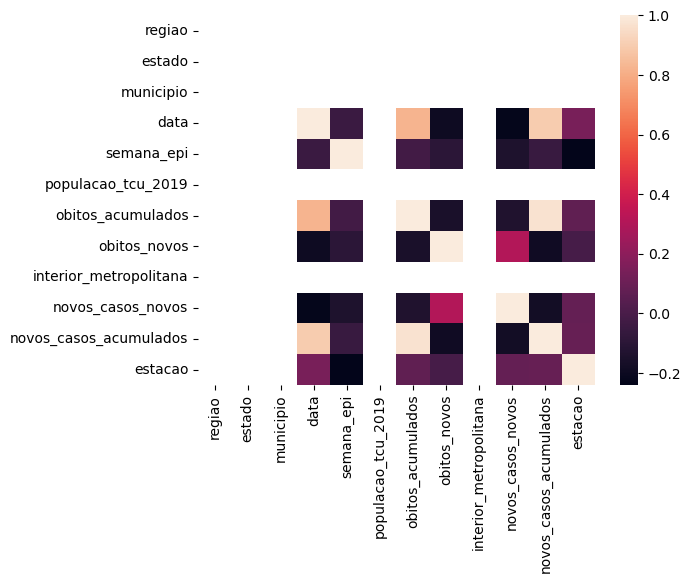

In [10]:
from seaborn import heatmap

heatmap(df.corr())

In [11]:
def _adicionar_lag_features(df):
    df["novos_casos_novos_lag_1"] = df['novos_casos_novos'].shift(1)
    df["obitos_novos_lag_1"] = df['obitos_novos'].shift(1)

    df["novos_casos_novos_lag_7"] = df['novos_casos_novos'].shift(7)
    df["obitos_novos_lag_7"] = df['obitos_novos'].shift(7)

    df["novos_casos_novos_lag_14"] = df['novos_casos_novos'].shift(14)
    df["obitos_novos_lag_14"] = df['obitos_novos'].shift(14)

    return df

def _adicionar_media_movel_7(df):
    df['novos_casos_novos_media_movel_7'] = df['novos_casos_novos'].transform(lambda x: x.shift(1).rolling(7).mean())
    df['obitos_novos_media_movel_7'] = df['obitos_novos'].transform(lambda x: x.shift(1).rolling(7).mean())

    return df

In [12]:
def _rodar_engenharia_de_atributos(df):
    df = _adicionar_lag_features(df)
    df = _adicionar_media_movel_7(df)

    return df

In [13]:
from tqdm import tqdm

def _processar(df):
    logging.info("Processando municipios_unicos")
    municipios_unicos = set(zip(df['municipio'], df['estado']))
    logging.info("Processamento concluído")

    logging.info("Filtrando o dataframe ")
    mascara = df.apply(lambda x: (
        x['municipio'], x['estado']) in municipios_unicos, axis=1)
    filtrado_df = df[mascara]
    logging.info("Processamento concluído")

    logging.info("Processando grupos")
    agrupado = filtrado_df.groupby(['municipio', 'estado'])
    logging.info("Processamento concluído")

    resultado_df = []

    for (municipio, estado), group_df in tqdm(agrupado, desc="Processando"):
        try:
            group_df = group_df.sort_values(by='data')
            resultado_df.append(_rodar_engenharia_de_atributos(group_df))
        except Exception as e:
            logging.error(f"{estado}_{municipio} não foi salvo")
            logging.error(e)

    resultado_df = pd.concat(resultado_df)
    return resultado_df

In [14]:
df = _processar(df)

2025-06-01 14:39:03 - INFO - Processando municipios_unicos
2025-06-01 14:39:03 - INFO - Processamento concluído
2025-06-01 14:39:03 - INFO - Filtrando o dataframe 
2025-06-01 14:39:03 - INFO - Processamento concluído
2025-06-01 14:39:03 - INFO - Processando grupos
2025-06-01 14:39:03 - INFO - Processamento concluído
Processando: 100%|██████████| 1/1 [00:00<00:00, 32.17it/s]


In [15]:
df.columns

Index(['regiao', 'estado', 'municipio', 'data', 'semana_epi',
       'populacao_tcu_2019', 'obitos_acumulados', 'obitos_novos',
       'interior_metropolitana', 'novos_casos_novos', 'novos_casos_acumulados',
       'estacao', 'novos_casos_novos_lag_1', 'obitos_novos_lag_1',
       'novos_casos_novos_lag_7', 'obitos_novos_lag_7',
       'novos_casos_novos_lag_14', 'obitos_novos_lag_14',
       'novos_casos_novos_media_movel_7', 'obitos_novos_media_movel_7'],
      dtype='object')

In [16]:
df.head(5)

,regiao,estado,municipio,data,semana_epi,populacao_tcu_2019,obitos_acumulados,obitos_novos,interior_metropolitana,novos_casos_novos,novos_casos_acumulados,estacao,novos_casos_novos_lag_1,obitos_novos_lag_1,novos_casos_novos_lag_7,obitos_novos_lag_7,novos_casos_novos_lag_14,obitos_novos_lag_14,novos_casos_novos_media_movel_7,obitos_novos_media_movel_7
2438831,0,0,0,2020-03-27,13,128589.0,0,0,0.0,0,0,1,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2438832,0,0,0,2020-03-28,13,128589.0,0,0,0.0,0,0,1,0.0,0.0,NaN,NaN,NaN,NaN,NaN,NaN
2438833,0,0,0,2020-03-29,14,128589.0,0,0,0.0,0,0,1,0.0,0.0,NaN,NaN,NaN,NaN,NaN,NaN
2438834,0,0,0,2020-03-30,14,128589.0,0,0,0.0,0,0,1,0.0,0.0,NaN,NaN,NaN,NaN,NaN,NaN
2438835,0,0,0,2020-03-31,14,128589.0,0,0,0.0,0,0,1,0.0,0.0,NaN,NaN,NaN,NaN,NaN,NaN


# XGBoost

In [17]:
from xgboost import XGBRegressor

def treinamento(df_treino, df_teste):
  X_treino, y_treino = df_treino[df_treino.columns.difference(['novos_casos_novos', 'data'])], df_treino[['novos_casos_novos']]
  X_teste = df_teste[df_teste.columns.difference(['novos_casos_novos', 'data'])]

  model = XGBRegressor()
  model.fit(X_treino, y_treino)

  coluna_predita = model.predict(X_teste)

  df_teste['predicao'] = coluna_predita

  return df_teste, model.feature_importances_


In [18]:
df_teste, feature_importances = treinamento(df.iloc[:-1], pd.DataFrame([df.iloc[-1]]))

df_teste.head(5)

,regiao,estado,municipio,data,semana_epi,populacao_tcu_2019,obitos_acumulados,obitos_novos,interior_metropolitana,novos_casos_novos,...,estacao,novos_casos_novos_lag_1,obitos_novos_lag_1,novos_casos_novos_lag_7,obitos_novos_lag_7,novos_casos_novos_lag_14,obitos_novos_lag_14,novos_casos_novos_media_movel_7,obitos_novos_media_movel_7,predicao
2440679,0,0,0,2025-04-18,16,128589.0,345,0,0.0,0,...,1,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.13807


# Darts

In [42]:
lags_future_covariates = ['regiao', 'estado', 'municipio', 'semana_epi', 'populacao_tcu_2019', 'interior_metropolitana', 'estacao']
lags_past_covariates = ['obitos_acumulados', 'obitos_novos', 
                     'novos_casos_novos_lag_1', 'obitos_novos_lag_1',
                     'novos_casos_novos_lag_7', 'obitos_novos_lag_7',
                     'novos_casos_novos_lag_14', 'obitos_novos_lag_14',
                     'novos_casos_novos_media_movel_7', 'obitos_novos_media_movel_7']
target = ['novos_casos_novos']
temporal_var = ['data']

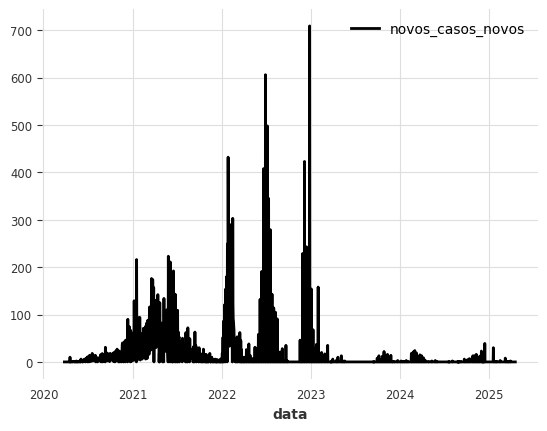

In [63]:
from darts import TimeSeries
import matplotlib.pyplot as plt

series_co = TimeSeries.from_dataframe(df[temporal_var + lags_past_covariates + lags_future_covariates], time_col="data", freq="D", fill_missing_dates=True)
series = TimeSeries.from_dataframe(df[temporal_var + target], time_col="data", freq="D", fill_missing_dates=True)
_ = series.plot()

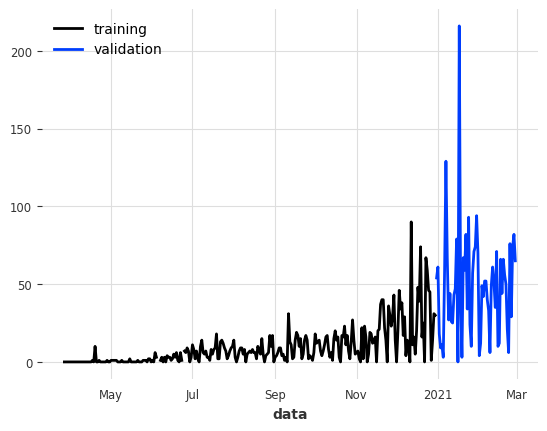

In [64]:
train, slice2 = series.split_before(pd.Timestamp("20201231"))
val, res = slice2.split_before(pd.Timestamp("20210301"))
_ = train.plot(label="training")
_ = val.plot(label="validation")

Encontrando o melhor k para o modelo baseline

In [ ]:
from darts.models import NaiveDrift, NaiveSeasonal
from darts.metrics import mae

errors = {}
for i in range(1, 90):
    model1 = NaiveSeasonal(K=i)
    model1.fit(train)
    seasonal_forecast = model1.predict(len(val))

    model2 = NaiveDrift()
    model2.fit(train)
    drift_forecast = model2.predict(len(val))

    combined_forecast = drift_forecast + seasonal_forecast - train.last_value()
    errors[i] = mae(val, combined_forecast)

sorted_by_values = dict(sorted(errors.items(), key=lambda item: item[1]))
sorted_by_values

{14: np.float64(25.191127098321342),
 42: np.float64(26.991606714628297),
 2: np.float64(27.439448441247002),
 7: np.float64(27.453956834532374),
 1: np.float64(27.57757793764988),
 49: np.float64(28.052038369304558),
 36: np.float64(28.484052757793766),
 6: np.float64(28.883333333333333),
 50: np.float64(28.884412470023978),
 35: np.float64(29.791007194244603),
 56: np.float64(29.854316546762586),
 63: np.float64(29.931414868105513),
 77: np.float64(30.014988009592326),
 41: np.float64(30.05383693045564),
 28: np.float64(30.38872901678657),
 43: np.float64(30.532254196642683),
 5: np.float64(30.608033573141483),
 3: np.float64(30.78429256594724),
 8: np.float64(30.791726618705034),
 64: np.float64(30.89208633093525),
 70: np.float64(31.06067146282974),
 62: np.float64(31.35071942446043),
 69: np.float64(31.365587529976022),
 18: np.float64(31.42434052757794),
 71: np.float64(31.65815347721822),
 84: np.float64(31.713429256594726),
 12: np.float64(31.94112709832134),
 16: np.float64(32

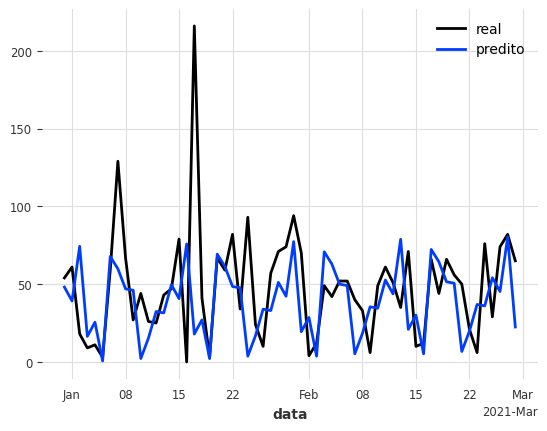

model NaiveSeasonal(K=14) obtains MAE: 27.58%
model NaiveDrift() obtains MAE: 26.27%
model NaiveDrift() obtains MAE: 25.19%


In [65]:
model1 = NaiveSeasonal(K=14)
model1.fit(train)
seasonal_forecast = model1.predict(len(val))

model2 = NaiveDrift()
model2.fit(train)
drift_forecast = model2.predict(len(val))

combined_forecast = drift_forecast + seasonal_forecast - train.last_value()
errors[i] = mae(val, combined_forecast)

val.plot(label='real')
combined_forecast.plot(label='predito')
plt.show()
plt.close()
print(f"model {model1} obtains MAE: {mae(val, drift_forecast):.2f}%")
print(f"model {model2} obtains MAE: {mae(val, seasonal_forecast):.2f}%")
print(f"model {model2} obtains MAE: {mae(val, combined_forecast):.2f}%")

model NaiveSeasonal(K=30) obtains MAPE: 0.88%


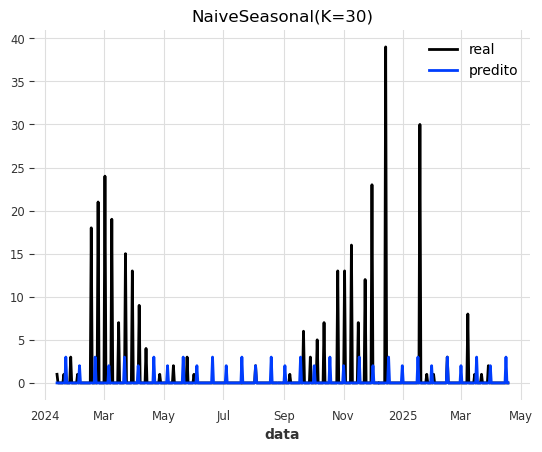

model NaiveDrift() obtains MAPE: 0.74%


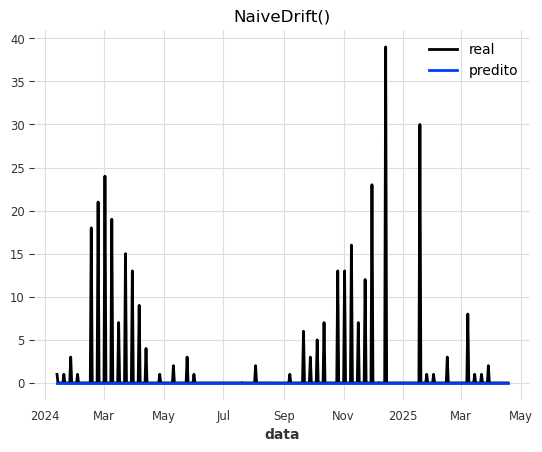

In [ ]:
def eval_model(model):
    model.fit(train)
    forecast = model.predict(len(val))
    print(f"model {model} obtains MAPE: {mae(val, forecast):.2f}%")
    
    val.plot(label='real')
    forecast.plot(label='predito')
    plt.title(model)
    plt.show()
    plt.close()

# eval_model(ExponentialSmoothing())
# eval_model(AutoARIMA())
# eval_model(Theta())
# eval_model(XGBModel())